# This notebook explores a dataset containing used car details and their selling prices on a site called CarDekho. The main objective is to clean and engineer the data to be ready for a model that can predict the a car's selling price.

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap as sp

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.utils import all_estimators
from sklearn.metrics import mean_squared_error, r2_score

from matplotlib.axes._axes import _log as matplotlib_axes_logger
from seaborn import heatmap
from scipy import stats

import warnings
matplotlib_axes_logger.setLevel("ERROR")
warnings.filterwarnings("ignore", category=FutureWarning)
sp.initjs()

In [2]:
data = pd.read_csv("cars.csv")
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
data.shape

(8128, 13)

# Looks like the model has some features that contain numbers coupled with their metrics (such as kmpl). Our first action will be to remove things such as the metrics from the numbers so that they can be used for regression models. We'll also extract the car manufacturer names from the car names.

In [4]:
def remove_non_digit(df): # Remove all non-digits from a column
    return df.apply(lambda x: "".join(char for char in str(x) if char.isdigit() or char in ",."))

def to_str_if_notempty_digit(s): # Convert to digit only string for the given regex match (if non-empty)
    if len(s) > 0:
        return "".join(x for x in s.pop() if x.isdigit())
    return np.nan

def to_str_if_notempty_char(s): # Convert to char only string for the given regex match (if non-empty)
    if len(s) > 0:
        return "".join(x for x in s[0] if x.isalpha())
    return np.nan

pattern_torque = re.compile(r"[\d,]{4,5}") # Torque regex pattern
pattern_name = re.compile(r"[a-zA-Z]{3,8}") # Car name regex pattern

def get_string(df, pattern, conv): # Convert all values in a column to proper strings, given the dataframe, pattern to search and conversion function (above)
    return df.apply(lambda x: conv(pattern.findall(str(x))))

In [5]:
for s in ["mileage", "engine", "max_power"]:
    data[s] = pd.to_numeric(remove_non_digit(data[s]))
data["torque"] = pd.to_numeric(get_string(data["torque"], pattern_torque, to_str_if_notempty_digit))
data["name"] = get_string(data["name"], pattern_name, to_str_if_notempty_char)
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,2000.0,5.0
1,Skoda,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,2500.0,5.0
2,Honda,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78.00,2700.0,5.0
3,Hyundai,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,2750.0,5.0
4,Maruti,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,4500.0,5.0


# Examine any missing data and take a proper course of action, in our case simple mean imputing.

In [6]:
print(data.isna().mean() * 100)
nan_cols = list(data.isnull().any(axis=0))

name             0.000000
year             0.000000
selling_price    0.000000
km_driven        0.000000
fuel             0.000000
seller_type      0.000000
transmission     0.000000
owner            0.000000
mileage          2.718996
engine           2.718996
max_power        2.657480
torque           3.149606
seats            2.718996
dtype: float64


In [7]:
# Since there isn't that much data missing, I will just impute the features with missing values using the mean.
imputer = SimpleImputer() 
data.loc[:,nan_cols] = imputer.fit_transform(data.loc[:,nan_cols])

In [8]:
data.describe().round(2)

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats
count,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00,8128.00
mean,2013.80,638271.81,69819.51,19.42,1458.63,91.52,3078.89,5.42
std,4.04,806253.40,56550.55,3.98,497.02,35.34,890.65,0.95
min,1983.00,29999.00,1.00,0.00,624.00,0.00,1400.00,2.00
25%,2011.00,254999.00,35000.00,16.80,1197.00,68.10,2500.00,5.00
50%,2015.00,450000.00,60000.00,19.42,1248.00,83.10,3000.00,5.00
75%,2017.00,675000.00,98000.00,22.28,1582.00,101.25,4000.00,5.00
max,2020.00,10000000.00,2360457.00,42.00,3604.00,400.00,5300.00,14.00


# Lets do some EDA to get some feeling for the data we're working with.

## Distributions using histograms.

Text(0.5, 0, 'seats')

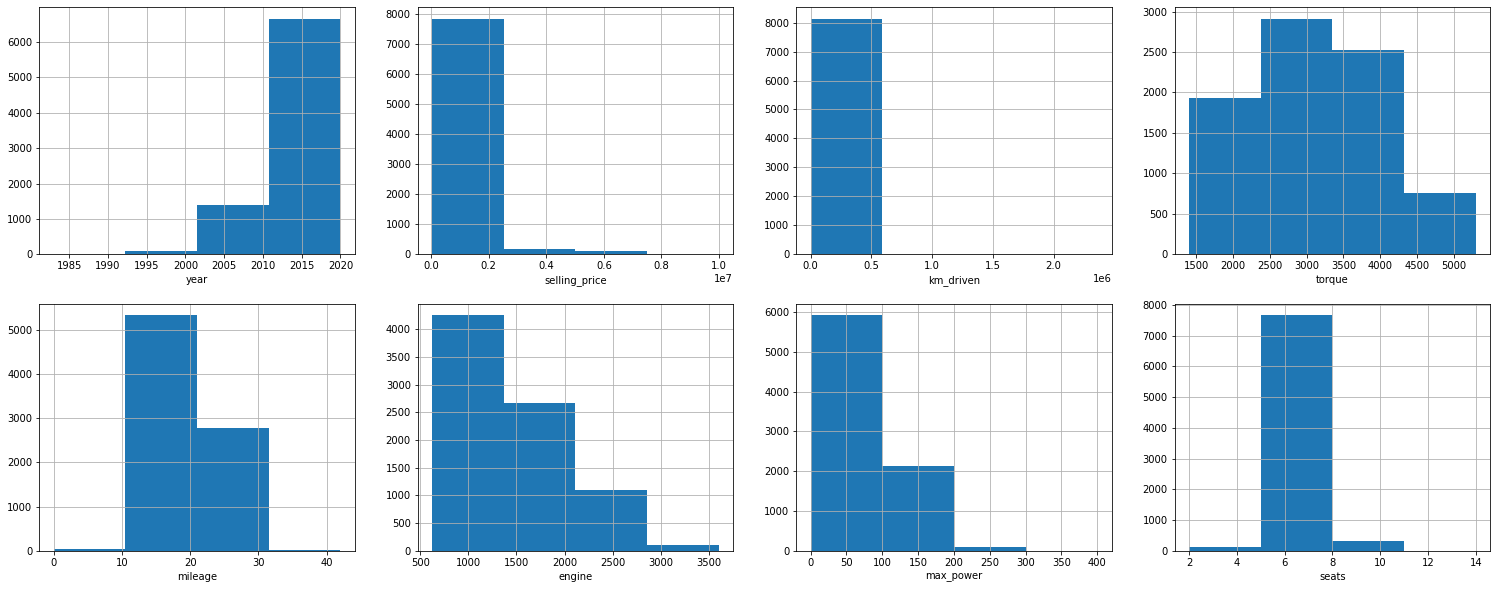

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(26, 10))
data.year.hist(bins=4, ax=axes[0][0])
axes[0][0].set_xlabel("year")
data.selling_price.hist(bins=4, ax=axes[0][1])
axes[0][1].set_xlabel("selling_price")
data.km_driven.hist(bins=4, ax=axes[0][2])
axes[0][2].set_xlabel("km_driven")
data.torque.hist(bins=4, ax=axes[0][3])
axes[0][3].set_xlabel("torque")

data.mileage.hist(bins=4, ax=axes[1][0])
axes[1][0].set_xlabel("mileage")
data.engine.hist(bins=4, ax=axes[1][1])
axes[1][1].set_xlabel("engine")
data.max_power.hist(bins=4, ax=axes[1][2])
axes[1][2].set_xlabel("max_power")
data.seats.hist(bins=4, ax=axes[1][3])
axes[1][3].set_xlabel("seats")

## Features compared to the selling prices. Some features don't seem very correlated with the selling price, such as km_driven, which is fairly surprising to me.

<AxesSubplot:xlabel='max_power', ylabel='selling_price'>

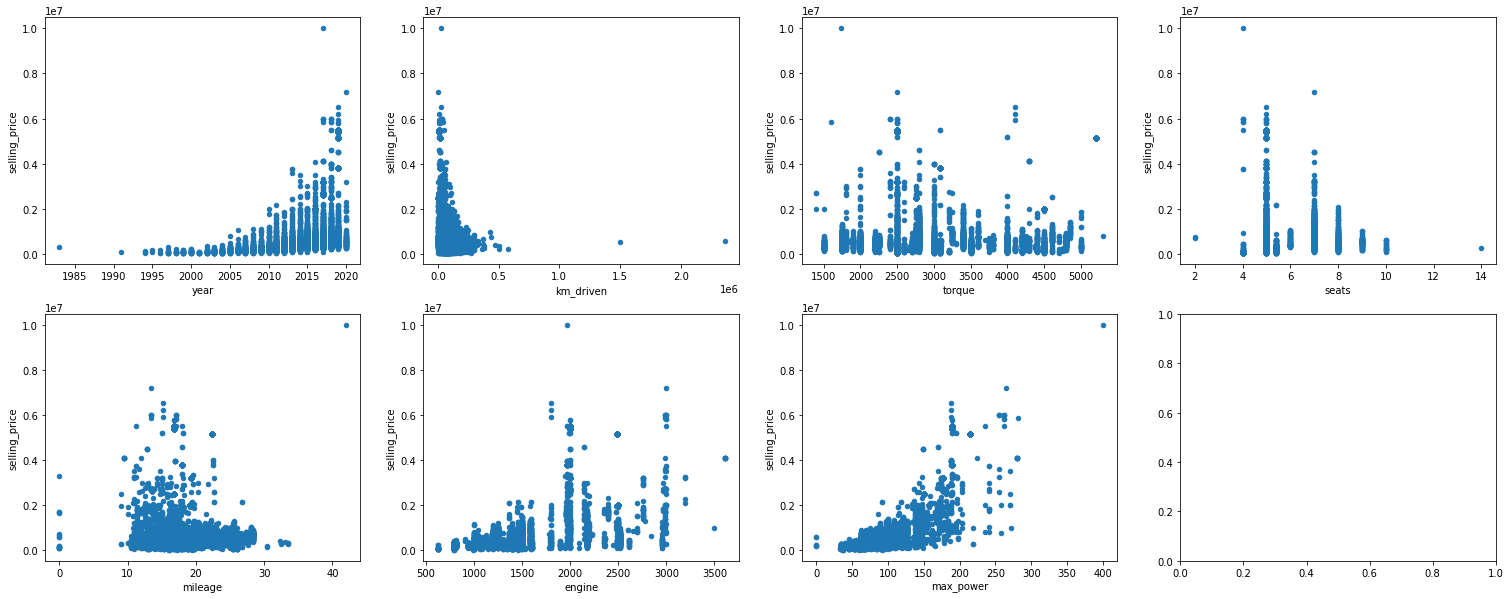

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(26, 10))
data.plot.scatter(x="year", y="selling_price", ax=axes[0][0])
data.plot.scatter(x="km_driven", y="selling_price", ax=axes[0][1])
data.plot.scatter(x="torque", y="selling_price", ax=axes[0][2])
data.plot.scatter(x="seats", y="selling_price", ax=axes[0][3])

data.plot.scatter(x="mileage", y="selling_price", ax=axes[1][0])
data.plot.scatter(x="engine", y="selling_price", ax=axes[1][1])
data.plot.scatter(x="max_power", y="selling_price", ax=axes[1][2])

# Converting categorical data to numeric ().

In [11]:
data.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage          float64
engine           float64
max_power        float64
torque           float64
seats            float64
dtype: object

In [12]:
for c in data:
    if data[c].dtype.name == "object":
        data[c] = pd.get_dummies(data[c], drop_first=True)
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,0,2014,450000,145500,1,1,1,0,23.40,1248.0,74.00,2000.0,5.0
1,0,2014,370000,120000,1,1,1,0,21.14,1498.0,103.52,2500.0,5.0
2,0,2006,158000,140000,0,1,1,0,17.70,1497.0,78.00,2700.0,5.0
3,0,2010,225000,127000,1,1,1,0,23.00,1396.0,90.00,2750.0,5.0
4,0,2007,130000,120000,0,1,1,0,16.10,1298.0,88.20,4500.0,5.0


# Lets check for possible extreme outliers by calculating the z-scores. Remove found extreme outliers, as they could harm our regression model.

In [13]:
z_scores = np.abs(stats.zscore(data))
threshold = 3.5 # The z-score threshold (X amount away from standard deviation) above which the value is classified as an outlier.
z_scores_over = np.where(z_scores > threshold)
data.drop(list(z_scores_over[0]), inplace=True)

# Show correlations as a heatmap.

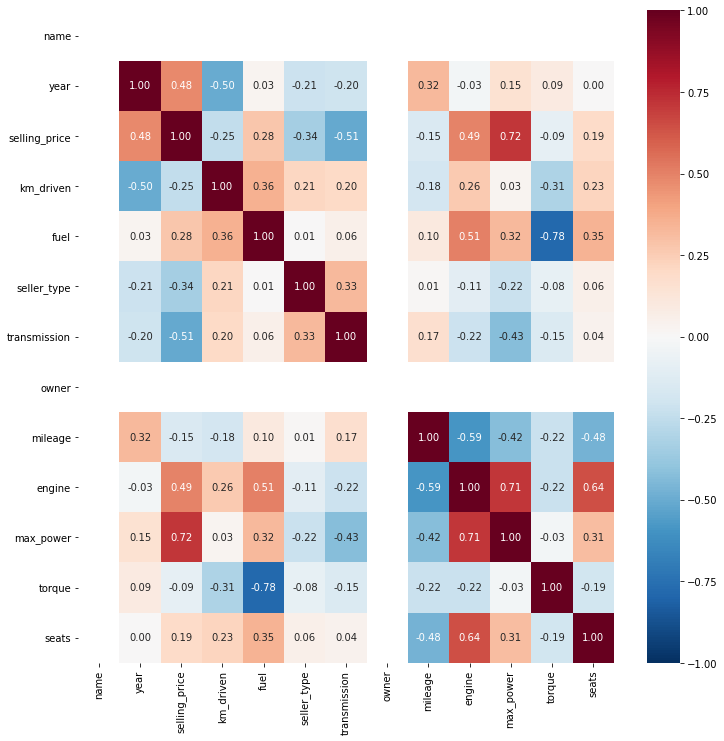

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))
ax = heatmap(
    data.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)

## There are some high positive and negative correlations, but so high as to justify discarding them.

# Standardize data, as many regression algorithms work better when data is standardized.

In [15]:
sscaler = StandardScaler()
cols = data.columns
data = pd.DataFrame(data=sscaler.fit_transform(data), columns=cols)
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,0.0,0.013466,-0.210959,1.783243,0.937569,0.439351,0.353659,0.0,0.978456,-0.378707,-0.498385,-1.231398,-0.447687
1,0.0,0.013466,-0.379322,1.196805,0.937569,0.439351,0.353659,0.0,0.388138,0.161313,0.483531,-0.667725,-0.447687
2,0.0,-2.131246,-0.825484,1.656757,-1.066588,0.439351,0.353659,0.0,-0.510400,0.159153,-0.365334,-0.442256,-0.447687
3,0.0,-1.058890,-0.684480,1.357788,0.937569,0.439351,0.353659,0.0,0.873975,-0.059015,0.033819,-0.385888,-0.447687
4,0.0,-1.863157,-0.884411,1.196805,-1.066588,0.439351,0.353659,0.0,-0.928325,-0.270703,-0.026054,1.586968,-0.447687


# Lets do some feature selection. We will use some tests to see if there are irrelevant features that we could remove to improve the accuracy of our model. We previously explored the correlation matrix already, but determined there wasn't high enough correlation to justify removing any features. Lets do some more digging.

## First, remove the target values from the data.

In [16]:
y = data.pop("selling_price")

## First score the features using KBest function with f_regression scoring. Unfortunately, this scoring function cannot deal with value zero so we'll have to resort to other methods too.

In [17]:
kbest = SelectKBest(score_func=f_regression, k="all")
with np.errstate(divide="ignore", invalid="ignore"):
    kbest_f = kbest.fit(data, y)
kbest_df = pd.DataFrame({"feature" : data.columns, "score" : kbest_f.scores_})
kbest_df = kbest_df.sort_values(by=["score"], ascending=False)
kbest_df.head(len(kbest_df))

,feature,score
9,max_power,7994.849486
5,transmission,2714.268305
8,engine,2442.066376
1,year,2257.046032
4,seller_type,1006.825700
3,fuel,645.551911
2,km_driven,493.410063
11,seats,276.794509
7,mileage,181.822446
10,torque,58.759345


## Secondly we use the feature importance feature that tree based algorithms have built in.

<AxesSubplot:>

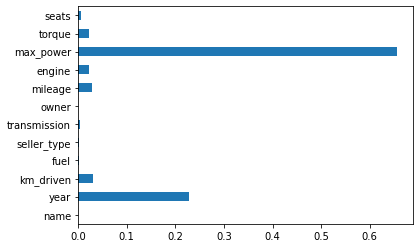

In [18]:
fi_rfc = RandomForestRegressor()
fi_rfc.fit(data, y)
fi_s = pd.Series(fi_rfc.feature_importances_, index=data.columns)
fi_s.plot(kind="barh")

## In addition to feature importance of tree based models, lets also check the coefficients of the ordinary linear regression model.

<AxesSubplot:>

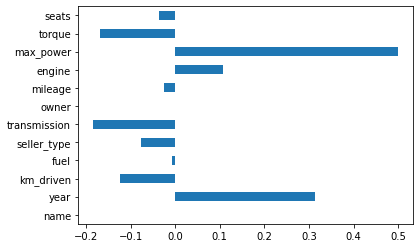

In [19]:
fi_lr = LinearRegression()
fi_lr.fit(data, y)
fi_s = pd.Series(fi_lr.coef_, index=data.columns)
fi_s.plot(kind="barh")

## Given our results I believe we can fairly confidently say that features owner and name do not contribute at all to the model and we will remove them from our data, as they could harm our regression models.

In [20]:
data.drop(["owner", "name"], axis=1, inplace=True)

# Split data into training and testing set.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.25)

# Baseline model. Our goal is to get, hopefully, a much better score than this using more advanced models.

In [22]:
lr_base = LinearRegression()
lr_base.fit(X_train, y_train)
print(f"Baseline model (default Linear Regression) score: {lr_base.score(X_test, y_test)}")

Baseline model (default Linear Regression) score: 0.7127276487167561


# Lets test some estimators and compare them to our baseline model. We will test all regressors in the sklearn library and XGBRegressor, CatBoostRegressor and LGBMRegressor gradient boosters, all which external to sklearn.

In [23]:
def append_score(r, scores):
    n_r = r[1]()
    if r[0] == "CatBoostRegressor":
        n_r.fit(X_train, y_train, silent=True)
    else:
        n_r.fit(X_train, y_train)
    scores.append([r[0], n_r.score(X_test, y_test)])

In [24]:
all_reg = all_estimators(type_filter="regressor")
all_reg_scores = []
try:
    for r in all_reg:
        append_score(r, all_reg_scores)
except:
    pass

all_reg_out = [("RandomForestRegressor", RandomForestRegressor), ("XGBRegressor", xgb.XGBRegressor), ("LGBMRegressor", lgb.LGBMRegressor), ("CatBoostRegressor", cb.CatBoostRegressor)]
for r in all_reg_out:
    append_score(r, all_reg_scores)
    
all_reg_scores_df = pd.DataFrame({"regressor" : [x[0] for x in all_reg_scores], "score" : [x[1] for x in all_reg_scores]})
all_reg_scores_df.sort_values(by=["score"], ascending=False, inplace=True)
all_reg_scores_df.head(len(all_reg_scores_df))

,regressor,score
14,CatBoostRegressor,0.949813
10,ExtraTreesRegressor,0.946831
11,RandomForestRegressor,0.945787
13,LGBMRegressor,0.943798
12,XGBRegressor,0.942776
2,BaggingRegressor,0.942737
5,DecisionTreeRegressor,0.909586
9,ExtraTreeRegressor,0.895479
8,ElasticNetCV,0.712961
3,BayesianRidge,0.712830


# It looks like the CatBoost regressor is the winner, although the top estimators are all close. We will be using the CatBoost regressor for our final model. Next, we'll be performing some hyperparameter tuning on our model.

In [25]:
params = {
    "n_estimators" : [10000],
    "learning_rate" : [0.04, 0.05],
    "depth" : [4, 8],
    "l2_leaf_reg" : [4.0, 8.0],
    "silent" : [True]
}

gs_cv = GridSearchCV(cb.CatBoostRegressor(), params, scoring="r2", n_jobs=-1)
gs_cv.fit(X_train, y_train)
print(f"""Best Params: {gs_cv.best_params_}
Best Score: {gs_cv.best_score_}""")

Best Params: {'depth': 4, 'l2_leaf_reg': 8.0, 'learning_rate': 0.04, 'n_estimators': 10000, 'silent': True}
Best Score: 0.9518472169803681


# Building the final regressor model.

In [26]:
reg = cb.CatBoostRegressor(**gs_cv.best_params_)
reg.fit(X_train, y_train)

# Evaluating, interpreting and visualizing our final regressor model.

In [27]:
pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
r2 = r2_score(y_test, pred)
print(f"""Model Scores
RMSE: {rmse}
R2: {r2}
""")

Model Scores
RMSE: 0.20655087243960377
R2: 0.951894145492276



## Quite excellent values. RMSE error is low (small difference between real and predicted values), while R2 score is very close to the best value, 1 (meaning movements in the predicted value can be explained by movements in the feature values).

## Lets see how the errors (residuals) in our model are distributed.

<AxesSubplot:title={'center':'Error Histogram'}, ylabel='Frequency'>

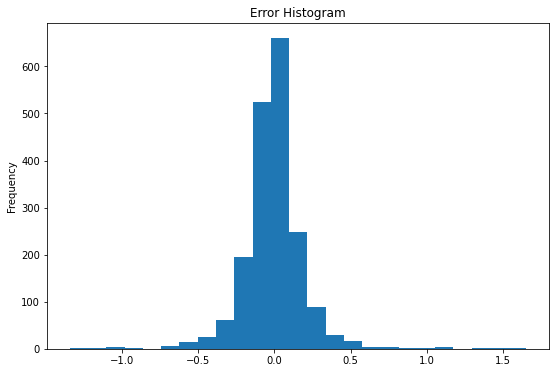

In [28]:
fig, ax = plt.subplots(figsize=(9, 6))
errors = y_test - pred
pd.Series(errors, name="errors").plot.hist(
    bins=25,
    ax=ax,
    title="Error Histogram"
)

## Most of the errors (differences between predicted and real values) in our model are around 0, which is excellent. There are some minor outliers but they're not a big bother.

## Finally, lets see how the features in our model impacted the outcome using a shapley summary plot, which uses SHAPLEY values to explain feature contributions. The features at the top contribute the most.

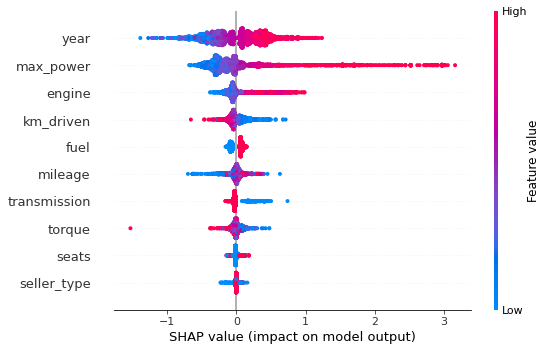

In [29]:
fig, ax = plt.subplots(figsize=(9, 6))
explainer = sp.TreeExplainer(reg)
values = explainer.shap_values(X_train)
sp.summary_plot(values, X_train)

## Quite interestingly, the shapley plot tells us that it is actually the year that contributes the most to the predicted outcome in our model, whereas the feature importance and regression coefficient methods showed that it was max_power.